In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [13]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [14]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, len(x)+1)/n
    return x,y

def plot_ecdf(df):
    ETD_orders = df.delta_est_ord_arrive_time.tolist()
    True_EDT_orders = df.delta_ord_arrive_time.tolist()
    model_ETD_orders = df.our_model_predict.tolist()
    
    x_est_ETD, y_est_ETD = ecdf(ETD_orders)
    x_ETD, y_ETD = ecdf(True_EDT_orders)
    x_model_ETD, y_model_ETD = ecdf(model_ETD_orders)
    
    _ = plt.plot(x_ETD, y_ETD)
    _ = plt.plot(x_est_ETD, y_est_ETD)
    _ = plt.plot(x_model_ETD, y_model_ETD)
    _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
    _ = plt.legend(['True ETD', 'EST ETD', 'model ETD predict'])
    
    _ = plt.show()
    

    
def draw_ecdf_models(df):
    states = X_test.customer_state.unique().tolist()  

    for s in states:
        plot_ecdf(df[clean_data.customer_state == s])

In [15]:
sellers_data = pd.read_csv('../input/olist_sellers_dataset.csv')
product_cat = pd.read_csv('../input/product_category_name_translation.csv')
orders_dataset = pd.read_csv('../input/olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('../input/olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('../input/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('../input/olist_geolocation_dataset.csv')
order_payments_dataset = pd.read_csv('../input/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('../input/olist_order_reviews_dataset.csv')
products_dataset = pd.read_csv('../input/olist_products_dataset.csv')




## Improve ETD accuracy

Build model which predict for items withing range of 7 days. In order to do that we have to
- assembly the part which is primary needed for prediction.
- drop their prediction columns since it has a large shift.
- drop Nan
- drop any delivery with status canceled 
- drop any orders for which time taken to postal office is more than 7 days


In [16]:
df_all = pd.merge(orders_dataset, customers_dataset, on='customer_id')
df_all = pd.merge(order_items_dataset, df_all, on='order_id')

In [17]:
if 'order_estimated_delivery_date' in df_all.columns:
    df_all.drop(columns=['order_estimated_delivery_date'], inplace=True)

In [18]:
df_all['order_purchase_timestamp'] = pd.to_datetime(df_all.order_purchase_timestamp)

In [19]:
clean_data = df_all.dropna()
clean_data = clean_data[clean_data.order_status == 'delivered']

In [20]:
clean_data['shipping_limit_date'] = pd.to_datetime(clean_data.shipping_limit_date)
clean_data['order_approved_at'] = pd.to_datetime(clean_data.order_approved_at)
clean_data['order_delivered_carrier_date'] = pd.to_datetime(clean_data.order_delivered_carrier_date)
clean_data['order_delivered_customer_date'] = pd.to_datetime(clean_data.order_delivered_customer_date)

## the accuracy of the model has to be tested for following cases
1. it has long approvment delay
2. it has not long delay

## Measure
1. clean_data.order_delivered_carrier_date - clean_data.order_approved_at
2. clean_data.order_delivered_carrier_date - clean_data.order_purchase_timestamp

__order_purchase_timestamp__: Shows the purchase timestamp.

__order_approved_at__: Shows the payment approval timestamp.

__order_delivered_carrier_date__: Shows the order posting timestamp. When it was handled to the logistic partner.

__order_delivered_customer_date__: Shows the actual order delivery date to the customer.



In [21]:
week_perious = clean_data.order_delivered_carrier_date - clean_data.order_approved_at < pd.to_timedelta("8 day")
clean_data['since_approved_carried'] = (clean_data.order_delivered_carrier_date - clean_data.order_approved_at).dt.days
clean_data['since_bought_carried'] = (clean_data.order_delivered_carrier_date - clean_data.order_purchase_timestamp).dt.days

clean_data['since_approved_customer'] = (clean_data.order_delivered_customer_date - clean_data.order_approved_at).dt.days
clean_data['since_bought_customer'] = (clean_data.order_delivered_customer_date - clean_data.order_purchase_timestamp).dt.days


We would define the time internal as follows:

   ```clean_data['since_bought_customer'] = (clean_data.order_delivered_customer_date - clean_data.order_purchase_timestamp).dt.days```
   
   
and portion which we are interesting has upper limit 7 at order_delivered_customer_date
    

In [22]:
df = clean_data[clean_data.since_bought_customer < 8]

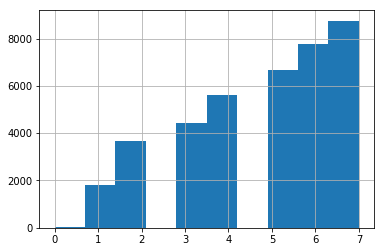

In [23]:
df.since_bought_customer.hist()


In [67]:
df.since_approved_customer.describe()

count    38720.000000
mean         4.477763
std          1.885887
min         -7.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: since_approved_customer, dtype: float64

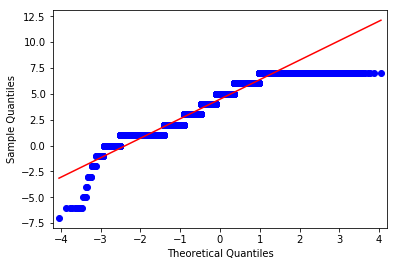

In [69]:
import statsmodels.api as sm
import pylab

sm.qqplot(df.since_approved_customer, loc = 4.803538, scale = 1.812803, line='s')
pylab.show()

Therefore this doesn't follow normal distribution pattern. We have to think about other feature.
## building feature
1. use the distance of seller till the geolocation of postal office
2. pretrain network on DHL dataset then retrain it on this dataset


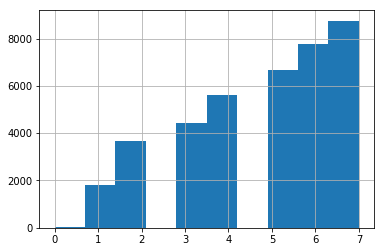

In [29]:
df.since_bought_customer.hist()

##  Pick better fulfillment plans, better meaning "faster" or "cheaper"


In [21]:
# code goes below
# find the min of time which takes to an item to arrive

## Improve conversion and maximize revenue by dynamically pricing premium delivery options for loyal customers

at least one of the following criteria might help
1. Predict cancellation of an item before it has been shipped 

In [22]:
# code goes below


In [23]:
# reference https://www.kaggle.com/lukio43/a-simple-analysis-of-delayed-orders
# https://blog.postmates.com/estimating-delivery-times-a-case-study-in-practical-machine-learning-e70f677e736c
# try to predict the optimal waiting time before an item has been shifted